In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
import random
import math
import matplotlib.pyplot as plt
from jax.example_libraries import stax, optimizers
from sklearn.model_selection import train_test_split
from jax import value_and_grad
from sklearn.metrics import accuracy_score




In [ ]:
def plot(images, labels):
    fig = plt.figure(figsize=(19,19))
    for i, image in enumerate(images):
      axs =fig.add_subplot(len(images)/2,len(images)/2,i+1)
      plt.title(f"{map_label(labels[i])}")
      axs.imshow(image, cmap='gray')


In [ ]:
def map_label(label):
  if label == 0:
    return 'square'
  elif label == 1:
    return 'triangle'
  else :
    return 'circle'

In [ ]:
def draw_rectangle(image):
  length, height = image.shape
  padding = 3
  width_r = int(height/2.5)
  height_r = int(height/3)
  top_x , top_y = random.choice(range(padding, length - width_r - padding )), random.choice(range(padding, height- height_r - padding))
  start_y, end_y = top_y, (top_y+ height_r)
  start_x, end_x = top_x, (top_x + width_r)
  for i in range(start_y, end_y):
    for j in range(start_x, end_x):
      image[i, j] = 255.0
  if random.random() > 0.5 :
    image = np.rot90(image, axes=(1,0))
    distort_image(image)
  return image

In [ ]:
def draw_triangle(image):
  length, height = image.shape
  triangle_height = int(height/3)
  padding = 3
  triangle_width = math.ceil((2/math.sqrt(3))* triangle_height)
  x_range = range(int(triangle_width/2) + padding, length - int(triangle_width/2) - padding)
  top_x , top_y = random.choice(x_range), random.choice(range(0, height-triangle_height - padding))
  start_y, end_y = top_y, (top_y + triangle_height)
  start_x = top_x
  end_x = start_x
  for i in range(start_y, end_y):
    for j in range(start_x, end_x):
      image[i, j] = 255.0
    start_x -=1
    end_x +=1
  if random.random() > 0.5 :
    image = np.rot90(image, axes=(1,0))
    distort_image(image)
  return image

In [ ]:
def draw_circle(image):
  length, height = image.shape
  padding = 3
  radius = (length + height)/9
  center_x , center_y = random.choice(range((int(radius)) + padding , length-int(radius) - padding)), random.choice(range((int(radius)) + padding, length-int(radius) - padding))
  for i, vector in enumerate(image):
    for j, val in enumerate(vector):
      dist = dist_bt_pts([i,j],[center_x, center_y])
      if (dist < radius):
        image[i,j] = 255.0
  if random.random() > 0.5 :
    distort_image(image)
  return image


In [ ]:
def distort_image(img):
  A = img.shape[0] / 10
  w = 2/ img.shape[1]

  shift = lambda x: A * np.sin(2.0*np.pi*x * w) * random.random()

  for i in range(img.shape[0]):
    img[:,i] = np.roll(img[:,i], int(shift(i)))


In [ ]:
def dist_bt_pts(a, b):
  x1, y1 = a[0], a[1]
  x2, y2 = b[0], b[1]
  x12 = (x1 - x2)**2
  y12 = (y1 - y2)**2
  dist = math.sqrt(x12 + y12)
  return dist

In [ ]:
def create_shape_db(): 
  no_of_images = 2048
  images = np.zeros((no_of_images, 28, 28), dtype=jnp.float32)
  image_labels = np.zeros(no_of_images,  dtype=jnp.float32)
  choice_of_images = range(1,4)
  for i, img in enumerate(images):
    choice = random.choice(choice_of_images)
    if (choice == 1):
        images[i] = draw_rectangle(images[i,:,:])
        image_labels[i] = 0
    elif (choice == 2):
        images[i] = draw_triangle(images[i,:,:])
        image_labels[i] = 1
    else:
        images[i] = draw_circle(images[i,:,:])
        image_labels[i] = 2

  plot(images[10:20,:,:], image_labels[10:20])
  return images, image_labels

2048 images of 28 x 28 are created which draw a circle, traingle or square in a uniform random fashion at different locations of the frame, along with appropriately labeled data for learning.

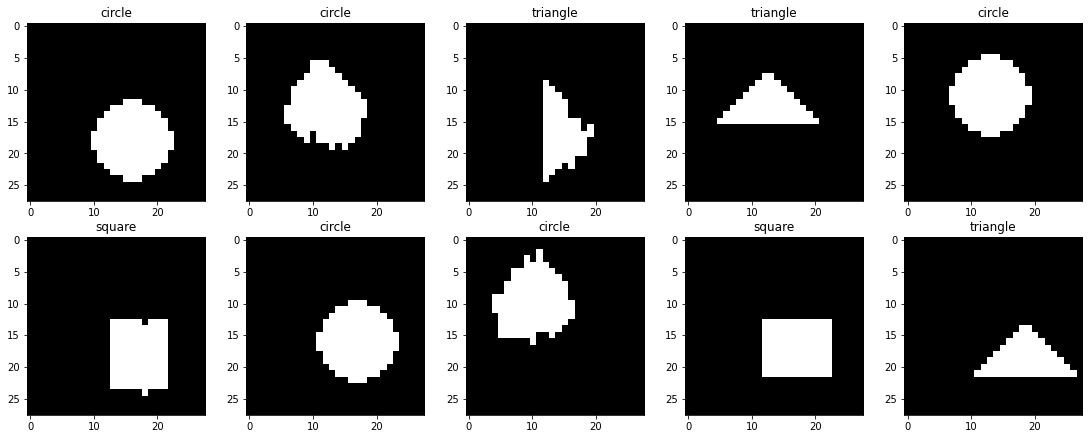

In [ ]:
images_db , image_labels = create_shape_db()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_db, image_labels, test_size=0.20, random_state=42)
classes =  jnp.unique(y_train)
X_train, X_test = X_train/255.0, X_test/255.0
X_train , X_test = X_train.reshape(-1, 28,28, 1), X_test.reshape(-1, 28,28, 1)
X_train.shape, X_test.shape

((1638, 28, 28, 1), (410, 28, 28, 1))

In [ ]:
conv_init, conv_apply = stax.serial(
    stax.Conv(6, (3,3), padding="SAME"),
    stax.Relu,
    stax.AvgPool((4,4)),
    stax.Flatten,
    stax.Dense(len(classes)),
    stax.Softmax
)

In [ ]:
rng = jax.random.PRNGKey(123)

weights = conv_init(rng, (18,28,28,1))

weights = weights[1] ## Weights are actually stored in second element of two value tuple

for w in weights:
    if w:
        w, b = w
        print("Weights : {}, Biases : {}".format(w.shape, b.shape))

Weights : (3, 3, 1, 6), Biases : (1, 1, 1, 6)
Weights : (3750, 3), Biases : (3,)


In [ ]:
preds = conv_apply(weights, X_train[:5])

preds

DeviceArray([[0.28153566, 0.37155795, 0.34690642],
             [0.2958105 , 0.34333777, 0.36085168],
             [0.31192058, 0.3387306 , 0.34934875],
             [0.29388705, 0.36298215, 0.3431308 ],
             [0.31387305, 0.34132168, 0.34480524]], dtype=float32)

In [ ]:
def cross_entropy_loss(weights, input_data, actual):
    preds = conv_apply(weights, input_data)
    one_hot_actual = jax.nn.one_hot(actual, num_classes=len(classes))
    log_preds = jnp.log(preds)
    theloss = - jnp.sum(one_hot_actual * log_preds)
    return theloss

In [ ]:

def train_in_batches(X, Y, epochs, opt_state, batch_size=32):
    lossline = jnp.array([0])
    for i in range(1, epochs+1):
        batches = jnp.arange((X.shape[0]//batch_size)+1) ### Batch Indices
        for batch in batches:
            if batch != batches[-1]:
                start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
            else:
                start, end = int(batch*batch_size), None

            X_batch, Y_batch = X[start:end], Y[start:end] ## Single batch of data

            loss, gradients = value_and_grad(cross_entropy_loss)(opt_get_weights(opt_state), X_batch,Y_batch)

            ## Update Weights
            opt_state = opt_update(i, gradients, opt_state)

            lossline = np.append(lossline, loss)

        print("CrossEntropyLoss : {:.3f}".format(jnp.array(lossline).mean()))
        
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,1,1)
    plt.title('lossline')
    ax.set_xlabel('updates across epochs')
    ax.set_ylabel('loss')
    ax.plot(lossline[1:])
    return opt_state

CrossEntropyLoss : 66.557
CrossEntropyLoss : 67.342
CrossEntropyLoss : 67.313
CrossEntropyLoss : 67.096
CrossEntropyLoss : 66.816
CrossEntropyLoss : 66.491
CrossEntropyLoss : 66.095
CrossEntropyLoss : 65.585
CrossEntropyLoss : 64.947
CrossEntropyLoss : 64.182
CrossEntropyLoss : 63.310
CrossEntropyLoss : 62.357
CrossEntropyLoss : 61.349
CrossEntropyLoss : 60.302
CrossEntropyLoss : 59.230
CrossEntropyLoss : 58.142
CrossEntropyLoss : 57.043
CrossEntropyLoss : 55.938
CrossEntropyLoss : 54.831
CrossEntropyLoss : 53.727
CrossEntropyLoss : 52.628
CrossEntropyLoss : 51.538
CrossEntropyLoss : 50.462
CrossEntropyLoss : 49.402
CrossEntropyLoss : 48.359
CrossEntropyLoss : 47.337
CrossEntropyLoss : 46.336
CrossEntropyLoss : 45.358
CrossEntropyLoss : 44.403
CrossEntropyLoss : 43.472
CrossEntropyLoss : 42.565
CrossEntropyLoss : 41.682
CrossEntropyLoss : 40.823
CrossEntropyLoss : 39.989
CrossEntropyLoss : 39.178
CrossEntropyLoss : 38.392
CrossEntropyLoss : 37.629
CrossEntropyLoss : 36.889
CrossEntropy

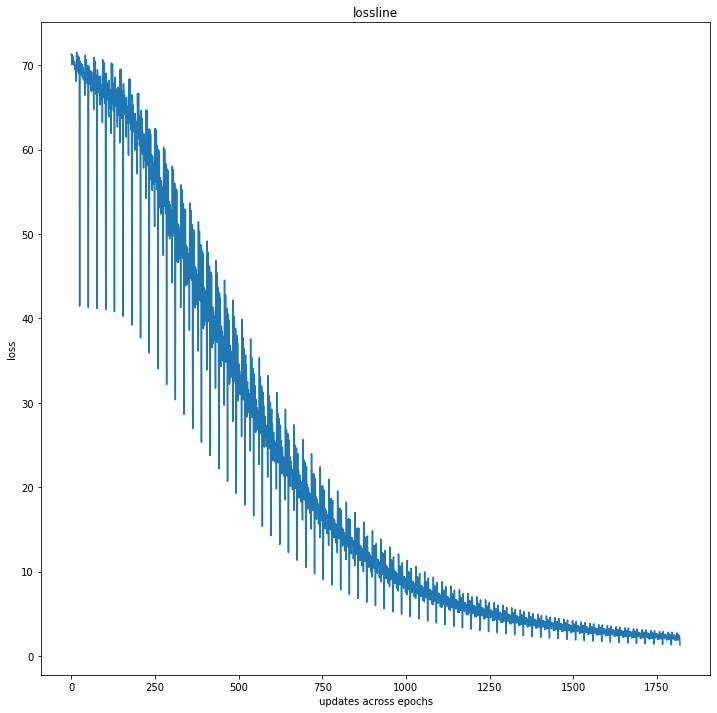

In [ ]:
seed = jax.random.PRNGKey(23)
learning_rate = jnp.array(1/1e4)
epochs = 70
batch_size=64

weights = conv_init(rng, (batch_size,28,28,1))
weights = weights[1]


opt_init, opt_update, opt_get_weights = optimizers.sgd(learning_rate)
opt_state = opt_init(weights)

final_opt_state = train_in_batches(X_train, y_train, epochs, opt_state, batch_size=batch_size)

In [ ]:


def predict(weights, input_data, batch_size=32):
    batches = jnp.arange((input_data.shape[0]//batch_size)+1) ### Batch Indices

    preds = []
    for batch in batches:
        if batch != batches[-1]:
            start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
        else:
            start, end = int(batch*batch_size), None

        X_batch = input_data[start:end]

        if X_batch.shape[0] != 0:
            preds.append(conv_apply(weights, X_batch))

    return preds



In [ ]:
test_preds = predict(opt_get_weights(final_opt_state), X_test, batch_size=batch_size)

test_preds = jnp.concatenate(test_preds).squeeze() ## Combine predictions of all batches
test_preds = jnp.argmax(test_preds, axis=1)

train_preds = predict(opt_get_weights(final_opt_state), X_train, batch_size=batch_size)

train_preds = jnp.concatenate(train_preds).squeeze() ## Combine predictions of all batches
train_preds = jnp.argmax(train_preds, axis=1)

In [ ]:
one_hot_y_train = jax.nn.one_hot(y_train, num_classes=len(classes))
y_train_ind = jnp.argmax(one_hot_y_train, axis=1)

one_hot_y_test = jax.nn.one_hot(y_test, num_classes=len(classes))
y_test_ind = jnp.argmax(one_hot_y_test, axis=1)


print(test_preds[:30], train_preds[:30])
print(y_test_ind[:30], y_train_ind[:30])

print("Train Accuracy : {:.3f}".format(accuracy_score(y_train_ind, train_preds)))
print("Test  Accuracy : {:.3f}".format(accuracy_score(y_test_ind, test_preds)))

[2 2 2 0 2 2 1 1 2 0 0 0 2 1 1 1 2 2 0 1 0 1 0 0 0 0 1 2 0 0] [0 2 0 1 1 1 0 1 0 2 1 1 0 0 0 2 1 0 2 0 2 0 0 2 0 1 1 1 2 0]
[2 2 2 0 2 2 1 1 2 0 0 0 2 1 1 1 2 2 0 1 0 1 0 0 0 0 1 2 0 0] [0 2 0 1 1 1 0 1 0 2 1 1 0 0 0 2 1 0 2 0 2 0 0 2 0 1 1 1 2 0]
Train Accuracy : 1.000
Test  Accuracy : 1.000
